# generic bulk model
<p>from mass balance + fick's</p>
<p>r. darling</p>

In [2]:
import numpy as np
from scipy import linalg
import pandas as pd
import matplotlib.pyplot as plt
import ipdb

In [3]:
# hydrogen pump -> local water content ?
# assume RH of feed will give water content
# 100% RH -> water activity of 1, vapor equilibriated
# in nafion, lmbda=14 (water content); transport nums as f(lmdba)

#S = 1.62 mg/kg
S = 2.2e-4 # ratio of hydrogen in surface of electrode to feed
c_feed = 3/1000 # conc of H2 in feed
#c_proton = 0.1 #1.1 #E+3 EW
c_proton = 0

## reference c*_oxidation and c*_reduction
c_H2_0 = 1
c_proton_0 = 1
P_tot = 1 #atm

z = 1
alpha = 0.5
T = 273.15 + 25 # Kelvin
R = 8.314
RT = R*T
E_eq = 0.0
#E = np.arange(-0.3,1.1,0.2)
n = 2

# a_v = 1e6
L = 50e-6 #15e-6
x = np.arange(0, L+0.5e-6, 0.5e-6)
i_0 = 2e-4
F = 96485.3
#D = 0.75e-5 #nafion
A = 0.0050 # prev: 20mm*20mm


---
# Molecular + Knudsen Diffusion

In [4]:
'''
Unfinished. Please do not use this cell !!
'''

v_H2 = 7.07
v_Ar = 16.1
MW_H2 = 2.02
MW_Ar = 39.95 
D_H2_Ar = (0.0017 * T**1.75)/(P_tot *(v_H2**(1/3) + v_Ar**(1/3))**2\
                             ) * np.sqrt(1/MW_H2 + 1/MW_Ar)

d_pore = 100*(10**(-10)) # 100 to 1000 Å 

D_H2_Kn = (1/3)*(d_pore)*np.sqrt((8*RT)/(np.pi*MW_H2)) 

porosity = 0.4
tortuosity = 0.3
D_eff_CL = tortuosity/porosity * (1/D_H2_Ar + 1/D_H2_Kn)


---

In [5]:
# 3M 1000 EW diffusivity
with open('D_3M_1000EW.txt', 'r') as f:
    dt_pair = f.readline()
    dt_vals = dt_pair.split('\t')
    D = float(dt_vals[1])*10**(-6) #diffusion for room temp
f.close()
print(D)

# concentration with rxn plugged in and corresponding current
# i_0 between e-2 to e-10
def c_cl(applied_potential, a_v=1e6, c_feed=3/1000, L=50e-6, i_0=2e-5, alpha=0.5):
    # FIXME: x -> linspace consistent with L
    x = np.arange(0, L+0.5e-6, 0.5e-6)
    b = alpha*z*F/RT*(applied_potential-E_eq)
    g = (a_v*i_0) / (c_H2_0*n*F*D) * np.exp(b)
    rt_g = np.sqrt(g)
    om = (c_proton*c_H2_0)/c_proton_0 * np.exp(-b - (1-alpha)/alpha * b)
    conc_cl = om + (c_feed-om)/(np.exp(-2*rt_g*L)+1)*(np.exp(-2*rt_g*L + rt_g*x) + np.exp(-rt_g*x))
    # if c_feed-om < 0:
    #     print('conc')
    # elif (1 - np.exp(-2*rt_g*L)) < 0:
    #     print('exp')
    current = (a_v * i_0 * 1/c_H2_0 * 1/rt_g) * np.exp(b) * (c_feed - om) * (1 - np.exp(-2*rt_g*L)) / (np.exp(-2*rt_g*L) + 1)
    return current, conc_cl


6.623376623376619e-06


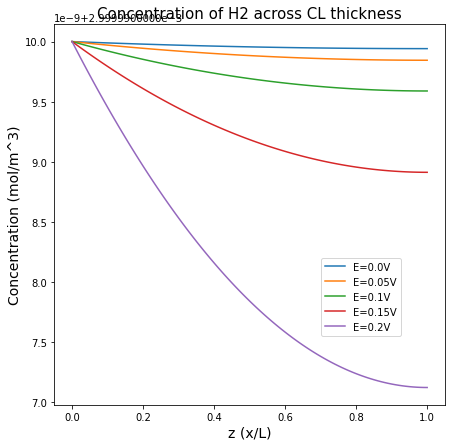

In [6]:
E = np.arange(0,0.21,0.05)
curr = []

plt.figure(figsize=(7,7))
for i in range(len(E)):
    curr1, conc1 = c_cl(E[i])
    curr.append(curr1)
    plt.plot(x/L, conc1, label=('E=' + str(round(E[i],2)) + 'V'))
    
#E=[0.6]
#plt.plot(x/L, c_cl(0), label=(str(round(E[0],2)) + 'V'), color='red')
plt.title('Concentration of H2 across CL thickness', fontsize='15')
plt.ylabel('Concentration (mol/m^3)', fontsize='14')
plt.xlabel('z (x/L)', fontsize='14')
#plt.grid(True,which="both", linestyle='--')
plt.legend(bbox_to_anchor=(0.9,0.4))
plt.show()


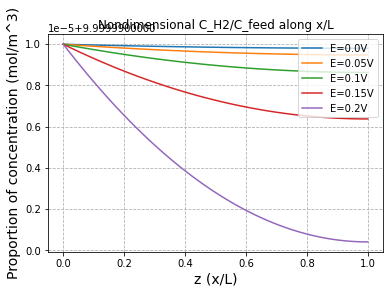

In [7]:
plt.figure()
I = []
E1 = E
for i in range(len(E1)):
    curr2, conc2 = c_cl(E1[i])
    plt.plot(x/L, (conc2/c_feed * 10), label=('E=' + str(round(E1[i],2)) + 'V'))
    I = np.append(I, curr2)

plt.title('Nondimensional C_H2/C_feed along x/L')
plt.ylabel('Proportion of concentration (mol/m^3)', fontsize='14')
plt.xlabel('z (x/L)', fontsize='14')
plt.grid(True,which="both", linestyle='--')
plt.legend(loc='upper right')
#plt.yscale('log')
plt.show()


---
# Model vs Experimental

In [8]:
with open('pump_potential.txt', 'r') as f:
    lines = f.readlines()
f.close()

pump_v = [] #potential
pump_a = [] #current
for i in lines:
    vals = i.split("\t")
    pump_a = np.append(pump_a, float(vals[0]))
    pump_v = np.append(pump_v, float(vals[1]))


## Current density

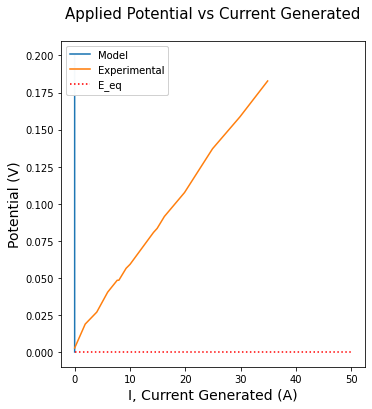

In [9]:
u_v = plt.figure(figsize=(12, 6))
ax = u_v.add_subplot(121)

# model current
model_v = ax.plot(I, E, label='Model')

# experimental current
exp_v = ax.plot(pump_a, pump_v, label='Experimental')
line1 = ax.hlines(0, xmin=0, xmax=50, color='red', linestyle=':', label='E_eq')

#ax2 = u_v.add_subplot(122)
#ax2.plot(curr,E)
#ax2.hlines(0, xmin=0, xmax=10, color='red',linestyle=':',label='E_eq')
#line2 = plt.axvline(0.875, color='orange',linestyle='-',label='I>0 (~0.875V)')
#ax2.set_xlim([0, 1.25])
#ax2.set_ylim([0, 0.3])

ax.set_title('Applied Potential vs Current Generated', fontsize='15', y=1.05)
ax.set_xlabel('I, Current Generated (A)', fontsize='14')
ax.set_ylabel('Potential (V)', fontsize='14')

leg1 = plt.legend(fontsize=10, loc='upper left')
plt.gca().add_artist(leg1)
plt.show()

---
# film-agglomerate spherical model
based on yoon 2011 (https://sci-hub.se/10.1149/1.3597644)

In [10]:
R_a = 0.1e-6 #0.1 micron, yoon
del_f = 20e-9
R_sph = R_a+del_f

D_agg = 8.45e-9 # O2 diffusion in Yoon = 8.45e-5 cm^2/s
D_CL = 2.30e-5

Df = 0.5e-5 #also check this
i_0 = 2e-4

# perm_H2_I = 5.64e-12 # [m^2/2] H2 permeability in thin film
agg_cl = 0.4 #agglomerate to CL ratio by weight
eps = 0.4 #porosity
L_Pt = 0.167 #0.2 mg Pt cm^-2
A_ca = 40

In [11]:
def constants(applied_potential, x_cl):
    theta = (i_0*L_Pt*A_ca)/((1-agg_cl)*L*c_H2_0*F)*np.exp(alpha*z*F*(applied_potential-E_eq)/RT)
    phi = np.sqrt(theta*R_sph/D_agg)
    #print("%5.2f, %5.2f" % (phi, R_sph/D_agg))
    omega = D_agg/Df * eps/np.sinh(phi*R_a/R_sph) * (-(R_a/R_sph)*np.sinh(phi*R_a/R_sph) + 
                                      (R_a/R_sph)**2*phi*np.cosh(phi*R_a/R_sph))
    p = (1-eps)*D_agg/(4/3*R_a*D_CL*np.sinh(phi*R_a/R_sph)
               ) * (R_sph/R_a) * ( phi*np.cosh(R_a/R_sph) - (R_sph/R_a)*np.sinh(phi*R_a/R_sph)
                                 ) * eps/(R_sph/R_a*omega - omega + 1)
    rt_p = np.sqrt(abs(p))
    k1 = 1/(1+np.exp(-2*rt_p*L))
    conc_bulk = combined_bulk(x_cl,k1, rt_p)
    c_film_0 = S*conc_bulk / (R_sph/R_a * omega - omega + 1)
    return [theta, phi, omega, rt_p, k1, conc_bulk, c_film_0]

## permeation from johnny's paper
def modified_thiele():
    T_ref = 30 + 273.15
    # permeation = (1.8E-11)*np.exp((18000/R)*(1/T_ref - 1/T))

def combined_bulk(x,k1,rt_p):
    return c_feed*((1-k1)*np.exp(rt_p*x) + k1*np.exp(-rt_p*x))

## concentration in agglomerate
def c_agg(zed):
    return (1/zed) * eps*c_film_0 * R_a/R_sph * np.sinh(phi*zed) / np.sinh(phi*R_a/R_sph)

## concentration in film
def c_film(zed):
    return S*conc_bulk + omega*c_film_0*(1-1/zed)


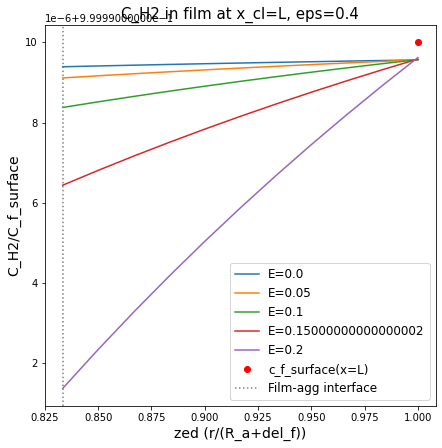

In [12]:
plt.figure(figsize=(7,7))

c_f_surf = S*c_feed # 1e-7 mol/cm^3, yoon
zed_i = np.arange(0.05e-8, R_a, 0.05e-8) / R_sph
zed_o = np.arange(R_a, R_sph+0.1*del_f, 0.1*del_f) / R_sph
x_cl = L

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

#E = [-0.3,0,0.3,0.5,0.6,0.7,0.8]
E2 = E[0:len(colors)]

j=0
for i in range(len(E1)):
    if j>len(colors):
        j=0
    [theta, phi, omega, rt_p, k1, conc_bulk, c_film_0] = constants(E1[i],x_cl)
    plt.plot(zed_o, c_film(zed_o)/c_f_surf, color=colors[j], label=('E='+str(E[i])))
    #plt.plot(zed_i, c_agg(zed_i)/c_f_surf, color=colors[j], label=('E='+str(E[i])))
    j+=1

dot = plt.plot(1,1,'o',color='red',label='c_f_surface(x=L)')
plt.title('C_H2 in film at x_cl=L, eps=0.4', fontsize='15')
plt.ylabel('C_H2/C_f_surface', fontsize='14')
#plt.grid(True,which="both", linestyle='--')
#plt.yscale('log')
plt.xlabel('zed (r/(R_a+del_f))', fontsize='14')
plt.axvline(R_a/R_sph, color='grey', linestyle=':', label='Film-agg interface')

plt.legend(fontsize='12')
#txt = 'Figure 5. Transport through the ionomer film increases with higher overpotential.'
#plt.text(0.5, -0.3, txt, horizontalalignment='center', fontsize=12)
plt.show()

---
## Parameter tuning

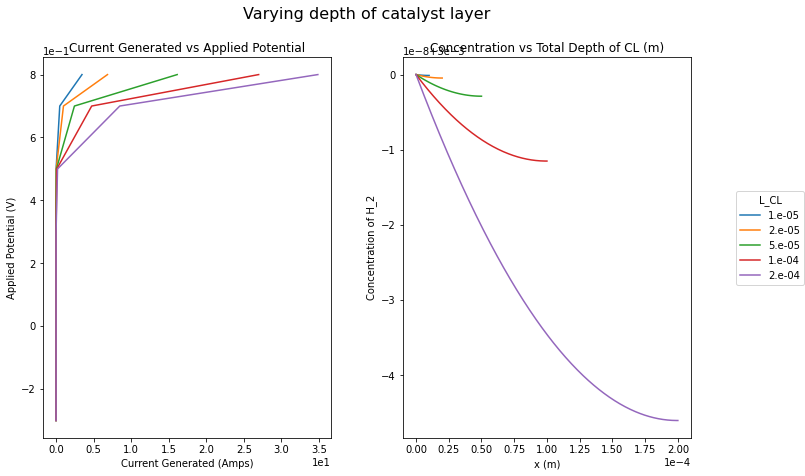

In [13]:
E_test = [-0.3, 0, 0.2, 0.3, 0.5, 0.7, 0.8]
test_L_arr = [10e-6, 20e-6, 50e-6, 100e-6, 200e-6]

fig_L, axs_L = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12,7))
fig_L.subplots_adjust(right=0.875, wspace=0.25)

for test_L in test_L_arr:
    test_curr = []

    for i in range(len(E_test)):
        test_i, test_c = c_cl(applied_potential=E_test[i], L=test_L)
        test_curr.append(test_i)

        if E_test[i] == 0.2:
            axs_L[1].plot(
                np.linspace(0, test_L, len(test_c)), test_c,
                label=str(np.round(test_L, 7)) + ' um')

    axs_L[0].plot(
        test_curr, E_test,
        label=np.format_float_scientific(test_L))

axs_L[0].set_xlabel('Current Generated (Amps)')
axs_L[0].set_ylabel('Applied Potential (V)')
axs_L[0].set_title('Current Generated vs Applied Potential')
axs_L[0].ticklabel_format(style='sci', scilimits=(0,0))

axs_L[1].set_xlabel('x (m)')
axs_L[1].set_ylabel('Concentration of H_2')
axs_L[1].set_title('Concentration vs Total Depth of CL (m)')
axs_L[1].ticklabel_format(style='sci', scilimits=(0,0))

fig_L.suptitle('Varying depth of catalyst layer', fontsize=16)

handles0, labels0 = axs_L[0].get_legend_handles_labels()
fig_L.legend(handles=handles0,
           labels=labels0,
           loc="center right",
           borderaxespad=0.1,
           title="L_CL"
           )


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Applied Potential (V)')

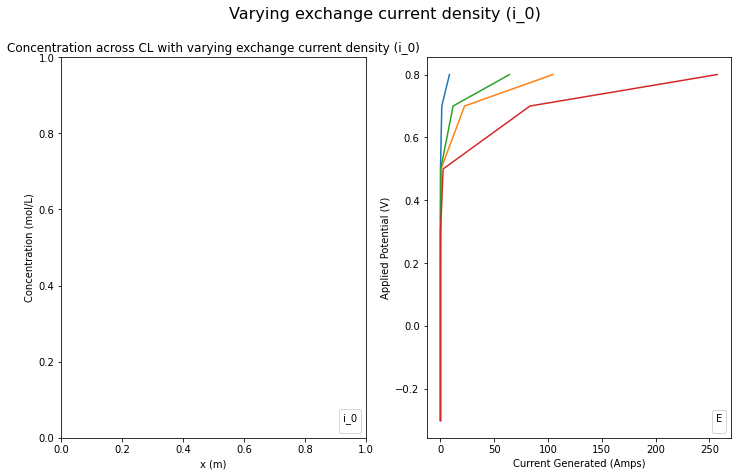

<Figure size 504x504 with 0 Axes>

In [26]:
test_i_0_arr = [1e-5, 2e-4, 1e-4, 10e-4]

fig1, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12,7))
for test_i_0 in test_i_0_arr:
    test_conc= []
    for i in range(len(E_test)):
        test_i, test_c = c_cl(applied_potential=E_test[i], i_0=test_i_0)
        test_conc.append(test_c)
    #axs[0].plot(np.linspace(0, L, len(test_conc)), test_conc, label=np.format_float_scientific(test_i_0))
fig1.suptitle('Varying exchange current density (i_0)', fontsize=16)
handles0, labels0 = axs[0].get_legend_handles_labels()
axs[0].set_xlabel('x (m)')
axs[0].set_ylabel('Concentration (mol/L)')
axs[0].set_title('Concentration across CL with varying exchange current density (i_0)')
axs[0].legend(title='i_0', loc='lower right')

plt.figure(figsize=(7,7))
for test_i_0 in test_i_0_arr:

    test_curr = []
    for i in range(len(E_test)):
        test_i, test_c = c_cl(applied_potential=E_test[i], i_0=test_i_0)
        test_curr.append(test_i)
    axs[1].plot(
        test_curr, E_test,
        label=np.format_float_scientific(test_i_0))
handles1, labels1 = axs[0].get_legend_handles_labels()
axs[1].legend(handles0, labels0, title='E', loc='lower right')
axs[1].set_xlabel('Current Generated (Amps)')
axs[1].set_ylabel('Applied Potential (V)')


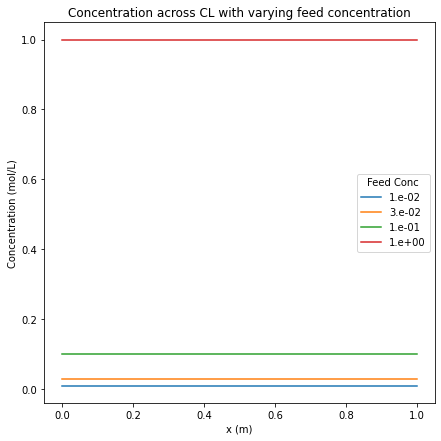

In [ ]:
E_param_tuning = 0.2
test_c_feed_arr = [1e-2, 3e-2, 1e-1, 1]

plt.figure(figsize=(7,7))
for test_c_feed in test_c_feed_arr:
    plt.plot(x/L, c_cl(applied_potential=0.2, c_feed=test_c_feed)[1], label=np.format_float_scientific(test_c_feed))

plt.xlabel('x (m)')
plt.ylabel('Concentration (mol/L)')
# plt.yscale('log')
plt.title('Concentration across CL with varying feed concentration')
plt.legend(title='Feed Conc')
plt.show()

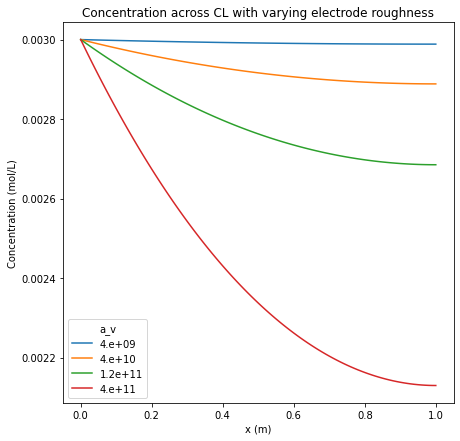

In [ ]:
E_param_tuning = 0.2
test_a_v_arr = [4e9, 4e10, 12e10, 4e11]

plt.figure(figsize=(7,7))
for test_a_v in test_a_v_arr:
    plt.plot(x/L, c_cl(applied_potential=0.2, a_v=test_a_v)[1], label=np.format_float_scientific(test_a_v))

plt.xlabel('x (m)')
plt.ylabel('Concentration (mol/L)')
plt.title('Concentration across CL with varying electrode roughness')
plt.legend(title='a_v')
plt.show()

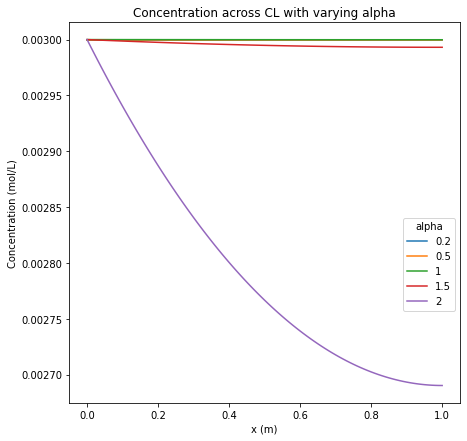

In [ ]:
E_param_tuning = 0.2
test_alpha_arr = [0.2, 0.5, 1, 1.5, 2]

plt.figure(figsize=(7,7))
for test_alpha in test_alpha_arr:
    plt.plot(x/L, c_cl(applied_potential=0.2, alpha=test_alpha)[1], label=test_alpha)

plt.xlabel('x (m)')
plt.ylabel('Concentration (mol/L)')
plt.title('Concentration across CL with varying alpha')
plt.legend(title='alpha', loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.show()

---
# Combined model

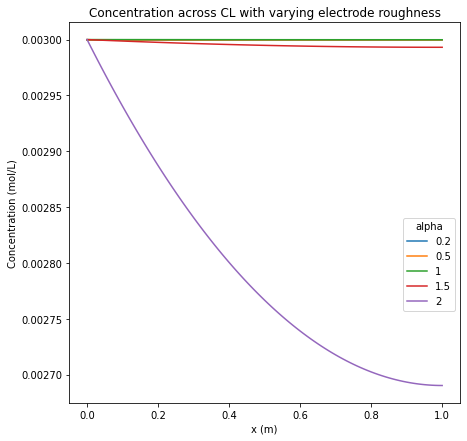

In [ ]:
E_param_tuning = 0.2
test_t = np.linspace(0.2, 2, 5)

plt.figure(figsize=(7,7))
for test_alpha in test_alpha_arr:
    plt.plot(x/L, c_cl(applied_potential=0.2, alpha=test_alpha)[1], label=test_alpha)

plt.xlabel('x (m)')
plt.ylabel('Concentration (mol/L)')
plt.title('Concentration across CL with varying electrode roughness')
plt.legend(title='alpha', loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.show()

$$
A \left[ -D \frac{\partial c_{bulk}}{\partial x} \mid _{x} - \left( -D \frac{\partial c_{bulk}}{\partial x} \right) \mid _{x+dx} \right] = \left( \frac{\text{rxn rate}}{\text{unit CL vol}} \right) A dx
$$

$$
-D \frac{\partial^2 c_{bulk}}{\partial x^2} = \frac{\text{reaction rate}}{\text{unit CL vol}}
$$

$$ \phi _{CL} = \frac{\text{void vol}}{\text{total CL volume}} $$

$$ \Delta V_{CL} (1-\phi_{CL}) = \text{solid vol in $\Delta V$ CL vol} $$

$$ \text{Num. of aggl. } = \frac{\Delta V_{CL} (1-\phi_{CL})}{\frac{4}{3} \pi R_{agg}^3} $$

$$ \text{Consum. per aggl. } = 4 \pi R_{agg}^2 \left[ -D_{agg} \frac{\partial c_{agg}}{\partial r} \right] $$

$$ \frac{\text{reaction rate}}{\text{unit CL vol}} = \left( \frac{\text{\# aggl.}}{\text{unit vol}}  \right) \left( \frac{\text{consump.}}{\text{aggl.}} \right) $$

$$ -D_{agg} \frac{\partial^2 c_{bulk}}{\partial r^2} = \left( \frac{1-\phi_{CL}}{\frac{4}{3} R_{agg}^3 } \right) \left( 4 \pi R_{agg}^3 \left[ -D_{agg} \frac{\partial c_{agg}}{\partial r} \right] \right) $$

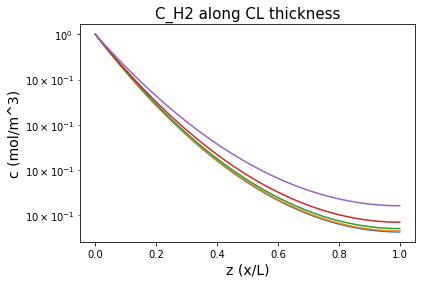

In [ ]:
# D_CL: https://escholarship.org/content/qt7kr960nf/qt7kr960nf.pdf
# De: https://sci-hub.se/10.1016/j.ijhydene.2018.07.035
# D_H2mix = 4.9e-5 for r_pore ~ 200nm

j=0
#E = np.arange(-0.3, 0.3, 0.05)
for i in range(len(E)):
    arr_c_bulk=[]
    for p in range(len(x)):
        [theta, phi, omega, rt_p, k1, conc_bulk, c_film_0] = constants(E[i], x[p])
        arr_c_bulk = np.append(arr_c_bulk, conc_bulk)
    plt.plot(x/L, arr_c_bulk/c_feed, label='E='+str(E[i]))

plt.title('C_H2 along CL thickness', fontsize='15')
plt.ylabel('c (mol/m^3)', fontsize='14')
plt.yscale('log')
plt.xlabel('z (x/L)', fontsize='14')
#plt.grid(True,which="both", linestyle='--')
#plt.legend()
plt.show()